In [11]:
import numpy as np
from math import sin, cos, pi
from random import randint, uniform
import matplotlib.pyplot as plt

In [12]:
t = np.arange(0, 2*pi, 0.025)
a = [0.4, 0.7, 1]
b = [0.15, 0.5, 1]
alpha = [pi/6,-pi/3,0]
x = lambda t,n: a[n]*cos(t)*cos(alpha[n]) - b[n]*sin(t)*sin(alpha[n])
y = lambda t,n: a[n]*cos(t)*sin(alpha[n]) + b[n]*sin(t)*cos(alpha[n])

## Первый этап

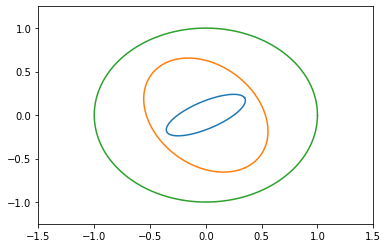

In [13]:
plt.xlim(-1.5, 1.5)
plt.ylim(-1.25, 1.25)
plt.plot([x(i,0) for i in t],[y(i,0) for i in t])
plt.plot([x(i,1) for i in t],[y(i,1) for i in t])
plt.plot([x(i,2) for i in t],[y(i,2) for i in t])

## Создание даты и выборок для обучения и теста

In [42]:
data = []
for i in t:
    data.append([[x(i,0),y(i,0)],[1,0,0]])
    data.append([[x(i,1),y(i,1)],[0,1,0]])
    data.append([[x(i,2),y(i,2)],[0,0,1]])

In [43]:
len(data)

756

In [44]:
cl = []
for i in t:
    cl.append([x(i,0),y(i,0)])
    cl.append([x(i,1),y(i,1)])
    cl.append([x(i,2),y(i,2)])

In [45]:
for i in np.arange(-1, 1, 0.05):
    for j in np.arange(-1, 1, 0.05):
        for dot in cl:
            if ((dot[0]-i)**2+(dot[1]-j)**2)**0.5 > 10**-2:
                data.append([[i,j],[0,0,0]])
                break

In [46]:
len(data)

2356

In [49]:
import random
random.shuffle(data)

## Создадим нейронную сеть с обратным распространением ошибки

In [82]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

In [51]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)

In [52]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

In [53]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p = np.clip(p, 1e-12, 1. - 1e-12)
        return -np.mean(np.multiply(y, np.log(p)) + np.multiply((1-y), np.log(1-p)))
    
    def backward(self,loss):
        return self.p - self.y

In [76]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)
    
    def compile(self, loss=None, metrics=["accuracy"]):
        self.loss = loss
        self.metrics = metrics
    
    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.loss.forward(p,y)
        true_label = np.argmax(y,axis=1)
        pred_label = np.argmax(p,axis=1)
        acc = (pred_label==true_label).mean()
        return l, acc
    
    def get_conf_mat(self, x, y):
        p = self.forward(x)
        true_label = np.argmax(y,axis=1)
        pred_label = np.argmax(p,axis=1)
        return confusion_matrix(pred_label, true_label)
    
    
    def fit(self, X_train, y_train, batch_size=4, epochs=5, validation_data=None, lr=0.3):
        X_test, y_test = validation_data
        history = []
        train_loss, train_acc = self.get_loss_acc(X_train, y_train)
        test_loss, test_acc = self.get_loss_acc(X_test, y_test)
        history.append([train_acc,train_loss,test_acc,test_loss])
        
#         for i in range(4):
#             print(f"Initial {['train_acc','train_loss','test_acc','test_loss'][i]}: {history[-1][i]}")

        for epo in range(epochs):
            for i in range(0,len(X_train),batch_size):
                xb = X_train[i:i+batch_size]
                yb = y_train[i:i+batch_size]
                p = self.forward(xb)
                l = self.loss.forward(p,yb)
                dp = self.loss.backward(l)
                dx = self.backward(dp)
                net.update(lr)
            train_loss, train_acc = self.get_loss_acc(X_train, y_train)
            test_loss, test_acc = self.get_loss_acc(X_test, y_test)
            history.append([train_acc,train_loss,test_acc,test_loss])
#             print(f"epoch: {epo+1}/{epochs}")
#             for i in range(4):
#                 print(f"{['train_acc','train_loss','test_acc','test_loss'][i]}: {history[-1][i]}")
#             print("confusion matrix:", self.get_conf_mat(X_train, y_train), sep='\n')
        return history

In [77]:
spl = int(len(data) * 0.8)
x_train,y_train = [],[]
for i in data[0:spl:]:
    x_train.append(i[0])
    y_train.append(i[1])
x_test,y_test = [],[]
for i in data[spl::]:
    x_test.append(i[0])
    y_test.append(i[1])

In [80]:
net = Net()
net.add(Linear(np.array(x_test).shape[-1], np.array(y_test).shape[-1]))
net.add(Softmax())
net.compile(loss=CrossEntropyLoss())

hist = net.fit(np.array(x_train), np.array(y_train), lr=0.01, epochs=50, batch_size=256, validation_data=(np.array(x_test), np.array(y_test)))

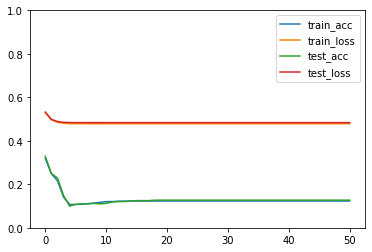

In [81]:
plt.clf()
plt.ylim(0, 1.0)
for i in range(4):
    plt.plot([val[i] for val in hist], label=['train_acc','train_loss','test_acc','test_loss'][i])
plt.legend()

## Второй этап

In [7]:
t = np.arange(0,3.5,0.01)
x = lambda t: sin(sin(t) * t**2 + 5 * t)